In [1]:
source("imports.r")
source("helpers.r")

In [2]:
doc <- "Usage:
  abundancy_diversity.R [--name <name>] [--wd <wd>]  <tsv> 

  Options:
    -w --wd <wd> [default: .]
    -n --name <name> Name of the sample
    -h --help Show this screen."

In [3]:
debug <- TRUE
if (debug == TRUE) {
  tsv <- file.path("/data", "samples", "AIRR-Seq", "OURS", "S3987Nr1", "S3987Nr1-PBMC_heavy", "subsamples", "sample_1000", "clones", "S3987Nr1-PBMC_heavy_with_clones.tsv")   
  args <- paste("--name S3987Nr1-PBMC_heavy", tsv)
  print(args)
  values <- docopt(doc, args = args, version = "0.1")
  print(values)
} else {
  values <- docopt(doc, version = "0.1")
}

[1] "--name S3987Nr1-PBMC_heavy /data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-PBMC_heavy/subsamples/sample_1000/clones/S3987Nr1-PBMC_heavy_with_clones.tsv"
List of 8
 $ --wd  : chr "."
 $ --name: chr "S3987Nr1-PBMC_heavy"
 $ --help: NULL
 $ <tsv> : chr "/data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-PBMC_heavy/subsamples/sample_1000/clones/S3987Nr1-PBMC_heavy_with_clones.tsv"
 $ wd    : chr "."
 $ name  : chr "S3987Nr1-PBMC_heavy"
 $ help  : NULL
 $ tsv   : chr "/data/samples/AIRR-Seq/OURS/S3987Nr1/S3987Nr1-PBMC_heavy/subsamples/sample_1000/clones/S3987Nr1-PBMC_heavy_with_clones.tsv"
NULL


In [4]:
tsv <- values$tsv
name <- values$name

### Calculate clone counts, coverage, abundancy and diversity ###

In [34]:
computeCloneCounts <- function(clones_results, name) {
    print("Computing clonotypes counts")
    counts <- alakazam::countClones(clones_results, copy = "duplicate_count")
    writeAnalysisTable(counts, build_filepath(name, "clone_counts", "tsv"))
    return(counts)
}

computeCoverage <- function(counts) {
    
    computeCoverage_subroutine <- function(max_order, counts) {
        orders <- 1:max_order
        coverages <- sapply(
            orders,
            function(order) { alakazam::calcCoverage(counts$seq_count, order) }
        )
        return(coverages)
    }
    
    tryCatchComputeCoverage <- function(counts, env) {
        coverages <- tryCatch({
                order <- get("order", env=env)
                return(computeCoverage_subroutine(order, counts))
            },
            error=function(cond) {
                order <- get("order", env=env)
                assign("order", order-1, env=env)
                print(paste0("Attempted coverage computation with order=", order,
                             "; Encountered error: ", cond, "; Attempting with order=", order-1))
                return(tryCatchComputeCoverage(counts, env))
            }
        )
        return(coverages)
    }
    
    compute_coverage_env <- new.env()
    assign("order", 10, env=compute_coverage_env)
    coverages <- tryCatchComputeCoverage(counts, compute_coverage_env)

    order <- get("order", env=compute_coverage_env)
    df <- data.frame(1:order, coverages)
    writeAnalysisTable(df, build_filepath(name, "coverages", "tsv"))
}

plotAbundancy <- function(abundanceCurve, name, filepath, debug) {
    sample_colors <- c(`-1h` = "seagreen", `+7d` = "steelblue")
    png(file = filepath, width = 800, height = 600)
    # Plots a rank abundance curve of the relative clonal abundances
    plot(abundanceCurve, colors = sample_colors, legend_title = name)
    if (debug == TRUE) {
      dev.off()
    }
    print(paste("abundances curve chart is written to", filepath))
    plot(abundanceCurve, colors = sample_colors, legend_title = name)  # to display in notebook
}
computeAbundancy <- function(clones_results, name, debug) {
    print("Calculates abundancy with 95% confidence interval via 200 bootstrap realizations")
    abundanceCurve <- alakazam::estimateAbundance(clones_results, ci = 0.95, nboot = 200, clone = "clone_id", progress = TRUE)
    writeAnalysisTable(abundanceCurve@abundance, build_filepath(name, "abundance_curve", "tsv"))
    plotAbundancy(abundanceCurve, name, build_filepath(name, "abundancy_curve", "png"), debug)
    return(abundanceCurve)
}

plotDiversity <- function(diversity, filepath, debug) {
    png(file = filepath, width = 800, height = 600)
    plot(diversity)
    if (debug == TRUE) {
      dev.off()
    }
    print(paste("diversity curve is written to", filepath))
    plot(diversity)
}
computeDiversity <- function(abundancyCurve, name, debug) {
    diversity <- alakazam::alphaDiversity(abundancyCurve)
    writeAnalysisTable(diversity@diversity, build_filepath(name, "diversity", "tsv"))
    plotDiversity(diversity, build_filepath(name, "diversity", "png"), debug)
    return(diversity)
}

[1] "Computing clonotypes counts"
[1] "Output is written to S3987Nr1-PBMC_heavy_clone_counts.tsv"
[1] "Attempted coverage computation with order=10; Encountered error: Error in alakazam::calcCoverage(counts$seq_count, order): Cannot calculate coverage of order 4. No abundance data with count=5.\n; Attempting with order=9"
[1] "Attempted coverage computation with order=9; Encountered error: Error in alakazam::calcCoverage(counts$seq_count, order): Cannot calculate coverage of order 4. No abundance data with count=5.\n; Attempting with order=8"
[1] "Attempted coverage computation with order=8; Encountered error: Error in alakazam::calcCoverage(counts$seq_count, order): Cannot calculate coverage of order 4. No abundance data with count=5.\n; Attempting with order=7"
[1] "Attempted coverage computation with order=7; Encountered error: Error in alakazam::calcCoverage(counts$seq_count, order): Cannot calculate coverage of order 4. No abundance data with count=5.\n; Attempting with order=6"
[

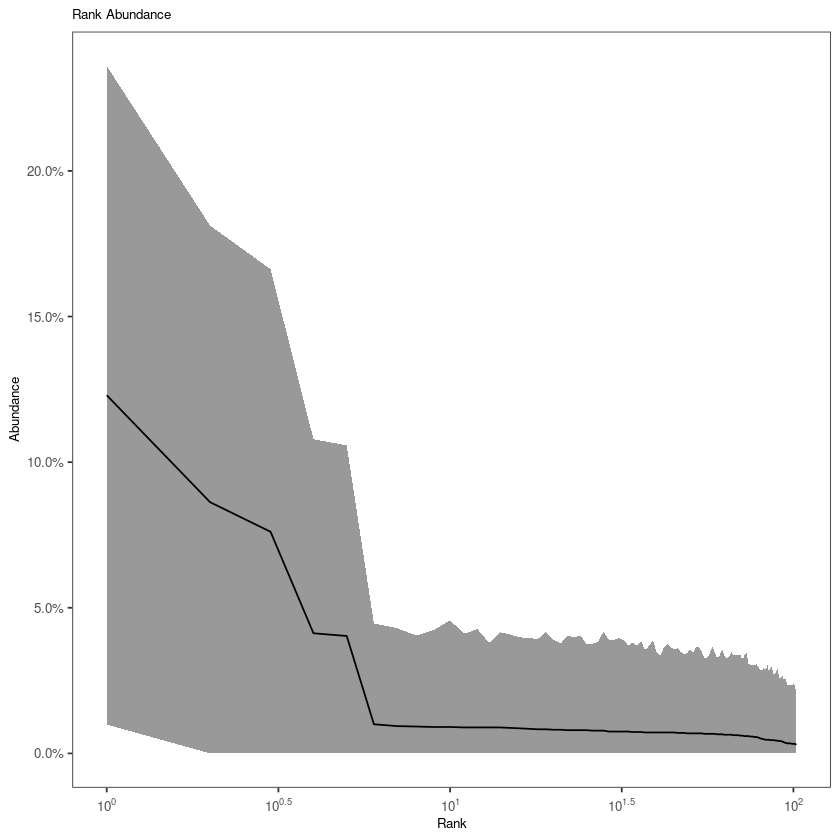

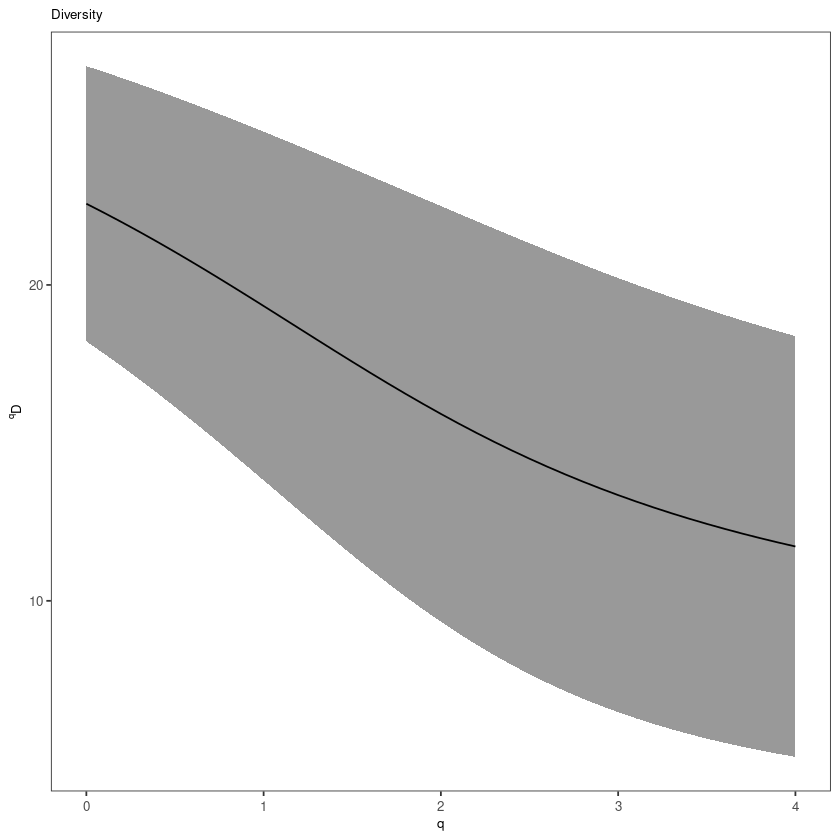

In [36]:
results <- alakazam::readChangeoDb(tsv)

counts <- computeCloneCounts(results, name)
computeCoverage(counts)
abundanceCurve <- computeAbundancy(results, name, debug)
diversity <- computeDiversity(abundanceCurve, name, debug)